## PHYS2600 Project 
### Band structure models of twisted bilayer graphene 
Based on Bistritzer and MacDonald, PNAS 2011 \
Erin Morissette \
8 April 2021

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from numba import jit 

In [123]:
# Setup, parameters for graphene
N = 3 # for 0.5 deg, need N = 5
a = 1.420 # Angstrom, 
w = 110.7 # meV 
vk = 1.5*a*2970 # meV/A
theta = 1.1

# Twist angle
theta = theta*(np.pi/180)
img = complex(0,1)

# For hopping matrices where phi = +/- 2pi/3 
eplus = np.cos(2*np.pi/3) - img*np.sin(2*np.pi/3)
emin = np.cos(2*np.pi/3) + img*np.sin(2*np.pi/3)

# Two Dirac points 
k1 = ((8*np.pi*np.sin(theta/2))/(3*np.sqrt(3)*a)) * np.array([-np.sqrt(3)/2, -1/2])
k2 = ((8*np.pi*np.sin(theta/2))/(3*np.sqrt(3)*a)) * np.array([-np.sqrt(3)/2, 1/2])

qb  = ((8*np.pi*np.sin(theta/2))/(3*np.sqrt(3)*a)) * np.array([0,-1])
qtl = ((8*np.pi*np.sin(theta/2))/(3*a)) * np.array([1/2, np.sqrt(3)/2])
qtr = ((8*np.pi*np.sin(theta/2))/(3*a)) * np.array([1/2, -np.sqrt(3)/2])


In [124]:
# Hopping matrices 
T1 = w * np.array([[1,1], [1,1]], dtype = complex)
T2 = w * np.array([[emin, 1], [eplus, emin]], dtype = complex)
T3 = w * np.array([[eplus, 1], [emin, eplus]], dtype = complex)

# Conjugate transpose hopping matrices 
T1dag = np.array(np.matrix(T1).H)
T2dag = np.array(np.matrix(T2).H)
T3dag = np.array(np.matrix(T3).H)
# print(T1, T2, T3)

In [125]:
# Create lattice 
L = []
L_inv = np.zeros([2*N+1, 2*N+1], int)

def Lattice(n):
    k = 0 
    for x in np.arange(-n, n+1):
        for y in np.arange(-n, n+1):
            L.append([x,y])
            L_inv[x+n,y+n] = k
            k += 1


In [126]:
# Establish lattice with truncation range N
Lattice(N)
sites = (2*N+1)*(2*N+1)
L = np.array(L)
# print(L)

In [127]:
# Build tight-binding Hamiltonian 
# For one valley
# @jit(nopython = True)
def Hamiltonian(kx, ky):
    Ham = np.array(np.zeros((4*sites, 4*sites)), dtype = complex) # each site includes a 4x4 matrix 
    
    for i in np.arange(sites): 
        ix = L[i,0]
        iy = L[i,1]
        
        ax = kx + k1[0] + ix*qtr[0] + iy*qtl[0]
        ay = ky + k1[1] + ix*qtr[1] + iy*qtl[1]
        
        # Rotation matrix times (ax,ay)
        qx = np.cos(theta/2)*ax + np.sin(theta/2)*ay
        qy = -np.sin(theta/2)*ax + np.cos(theta/2)*ay
        
        # Diagonal elements, each diagonal is an off-diagonal 2x2 matrix - the Dirac Hamiltonian
        Ham[2*i, 2*i + 1] = vk * (-qx - img*qy)
        Ham[2*i + 1, 2*i] = vk * (-qx + img*qy)
        
        # Off-diagonal elements, hopping matrices
        j = i + sites
#         Ham[2*j:2*j + 2, 2*i:2*i + 2] = T1dag
        Ham[2*j, 2*i]     = T1dag[0, 0]
        Ham[2*j, 2*i+1]   = T1dag[0, 1]
        Ham[2*j+1, 2*i]   = T1dag[1, 0]
        Ham[2*j+1, 2*i+1] = T1dag[1, 1]
        
        # Boundary conditions for T2 and T3    
        if (iy != -N):
            j = L_inv[ix + N, iy + N -1] + sites 
#             Ham[2*j:2*j + 2, 2*i:2*i + 2] = T2dag
            Ham[2*j, 2*i]     = T3dag[0, 0]
            Ham[2*j, 2*i+1]   = T3dag[0, 1]
            Ham[2*j+1, 2*i]   = T3dag[1, 0]
            Ham[2*j+1, 2*i+1] = T3dag[1, 1]
            
        if (ix != N):
            j = L_inv[ix + N + 1, iy + N] + sites
#             Ham[2*j:2*j + 2, 2*i:2*i + 2] = T3dag
            Ham[2*j, 2*i]     = T2dag[0, 0]
            Ham[2*j, 2*i+1]   = T2dag[0, 1]
            Ham[2*j+1, 2*i]   = T2dag[1, 0]
            Ham[2*j+1, 2*i+1] = T2dag[1, 1]
            
            
    for i in np.arange(sites, 2*sites): # everything the same except K1 to K2 and sign changes
        j = i - sites
        ix = L[j,0]
        iy = L[j,1]
        
        ax = kx + k2[0] + ix*qtr[0] + iy*qtl[0]
        ay = ky + k2[1] + ix*qtr[1] + iy*qtl[1]
        
        # Rotation matrix times (ax,ay)
        qx = np.cos(theta/2)*ax - np.sin(theta/2)*ay
        qy = np.sin(theta/2)*ax + np.cos(theta/2)*ay
        
        Ham[2*i, 2*i + 1] = vk * (-qx - img*qy)
        Ham[2*i + 1, 2*i] = vk * (-qx + img*qy)
        
#         Ham[2*j:2*j + 2, 2*i:2*i + 2] = T1
        Ham[2*j, 2*i]     = T1[0, 0]
        Ham[2*j, 2*i+1]   = T1[0, 1]
        Ham[2*j+1, 2*i]   = T1[1, 0]
        Ham[2*j+1, 2*i+1] = T1[1, 1]
           
        if (iy != (N)):
            j = L_inv[ix + N, iy + N + 1] 
#             Ham[2*j:2*j + 2, 2*i:2*i + 2] = T2
            Ham[2*j, 2*i]     = T3[0, 0]
            Ham[2*j, 2*i+1]   = T3[0, 1]
            Ham[2*j+1, 2*i]   = T3[1, 0]
            Ham[2*j+1, 2*i+1] = T3[1, 1]
            
        if (ix != (-N)):
            j = L_inv[ix + N - 1, iy + N] 
#             Ham[2*j:2*j + 2, 2*i:2*i + 2] = T3
            Ham[2*j, 2*i]     = T2[0, 0]
            Ham[2*j, 2*i+1]   = T2[0, 1]
            Ham[2*j+1, 2*i]   = T2[1, 0]
            Ham[2*j+1, 2*i+1] = T2[1, 1]
            
            
    eigval, eigvec = np.linalg.eig(Ham)
    eigenvalues = np.sort(eigval)
    
    return eigenvalues 

In [128]:
kres = 100 # resolution of the k ranges 
kD = -qb[1] # Dirac-point momentum 
krange1 = np.arange(-1/2, 1/2, 1/kres) # Gamma-K'
krange2 = np.arange(-1, 0, 1/kres) # K'-K''
krange3 = np.arange(0, np.sqrt(3), 1/kres) # K''-K
krange4 = np.arange(0, 1, 1/kres) # K-Gamma


# Setup energy matrix for all 4 k range segments 
krange = 3*kres + len(krange3) 
E  = np.zeros((krange,4*sites), float)

# compute the eigenvalues for each of the 4 ranges: Gamma-K', K'-K'', K''-K, and K-Gamma
for i in range(0, kres):
    k = krange1[i]
    E[i] = np.real(Hamiltonian((np.sqrt(3)/2)*kD, k*kD))
print('Done range 1.')
               
for i in range(kres, 2*kres):
    k = krange2[i-kres]
    E[i] = np.real(Hamiltonian(0, k*kD))
print('Done range 2.')
               
for i in range(2*kres, 2*kres + len(krange3)):
    k = krange3[i-2*kres]
    E[i] = np.real(Hamiltonian(0.5*k*kD, (-k*np.sqrt(3)/2)*kD))
print('Done range 3.')
               
for i in range(2*kres + len(krange3), krange):
    k = krange4[i-(2*kres + len(krange3))]
    E[i] = np.real(Hamiltonian((-np.sqrt(3)/2)*k*kD, (-1/2)*k*kD))
print('Done range 4.')

Done range 1.
Done range 2.
Done range 3.
Done range 4.


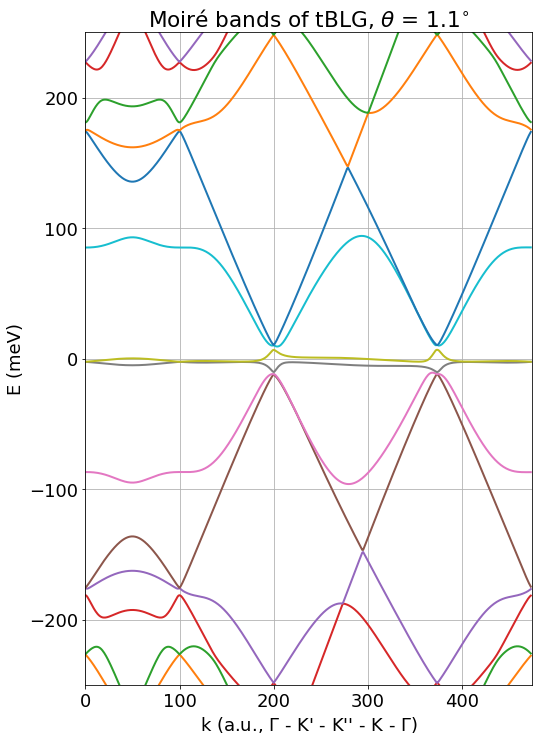

In [130]:
# Plot the bands as a function of the entire k range 
matplotlib.rcParams['figure.figsize'] = (8,12)
for j in range(0,4*sites):
    plt.plot(np.arange(krange), E[:,j], linestyle= '-', linewidth=2)

plt.title(r'Moiré bands of tBLG, $\theta$ = ' + str(round(theta*(180/np.pi), 3)) + '$^{\circ}$')
plt.xlim(0, krange)
plt.ylim(-250,250)
plt.ylabel('E (meV)')
plt.xlabel('k (a.u., $\Gamma$ - K\' - K\'\' - K - $\Gamma$)')
# labels = []
# plt.xticks(labels = ['$\Gamma$', 'K', 'K', 'K', '$\Gamma$'])
plt.grid()
plt.show()

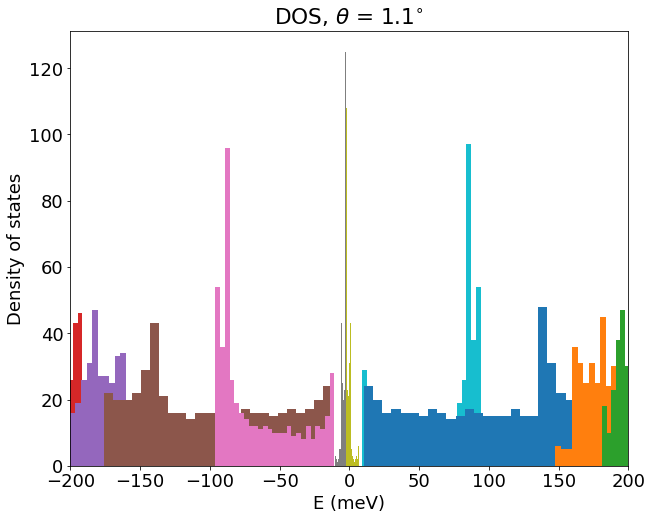

In [132]:
# Density of states histogram
matplotlib.rcParams['figure.figsize'] = (10,8)
for i in range(0, 4*sites):
    plt.hist(E[:,i], bins = 25)
plt.xlim(-200,200)
plt.xlabel('E (meV)')
plt.yticks(ticks = None)
plt.ylabel('Density of states')
plt.title(r'DOS, $\theta$ = ' + str(round(theta*(180/np.pi), 3)) + '$^{\circ}$')
plt.show()

### Kwant testing
Examples from Kwant documentation 

In [133]:
import kwant 

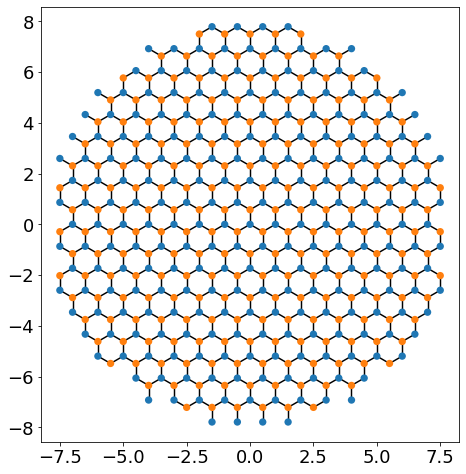

In [134]:
# Define honeycomb "lattice" for graphene 
def disk(pos):
    x, y = pos
    return x**2 + y**2 < 8**2

lat = kwant.lattice.honeycomb()
syst = kwant.Builder()
syst[lat.shape(disk, (0, 0))] = 0
syst[lat.neighbors()] = -1

kwant.plot(syst);


C:\Users\Erin Morissette\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: The plotted data contains 1.54% of values overflowing upper limit 0.0389414 
  # Remove the CWD from sys.path while we load stuff.


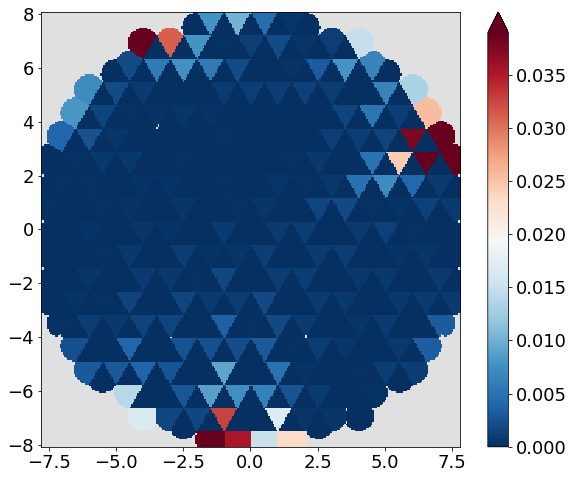

In [136]:
def plot_data(syst, n):
    import scipy.linalg as la

    syst = syst.finalized()
    ham = syst.hamiltonian_submatrix()
    evecs = la.eigh(ham)[1]

    wf = abs(evecs[:, n])**2
    
    kwant.plotter.map(syst, wf, oversampling=10, cmap='RdBu_r')
    
plot_data(syst,225)
    
# def site_size(i):
#         return 3 * wf[i] / wf.max()

# kwant.plot(syst, site_size=site_size, site_color=(0, 0, 1, 0.3),
#                hop_lw=0.1)